$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

<font size="8">**Optimizers**</font> 

<font size="5">**Table of Contents**</font>

- [Scaled Conjugate Gradient (SCG) Algorithm](#scg-introduction)
    - [The Scaled Part](#scaled-part)
    - [The Conjugate Part](#conjugate-part)
- [`optimizers.py`](#optimizerspy)
    - [SGD](#sgd)
    - [Adamw](#adamw)
    - [SCG](#scg)
- [Demonstrations](#demonstrations)

# Scaled Conjugate Gradient (SCG) Algorithm 
<a id='scg-introduction'></a>

## The Scaled Part
<a id="scaled-part"></a>

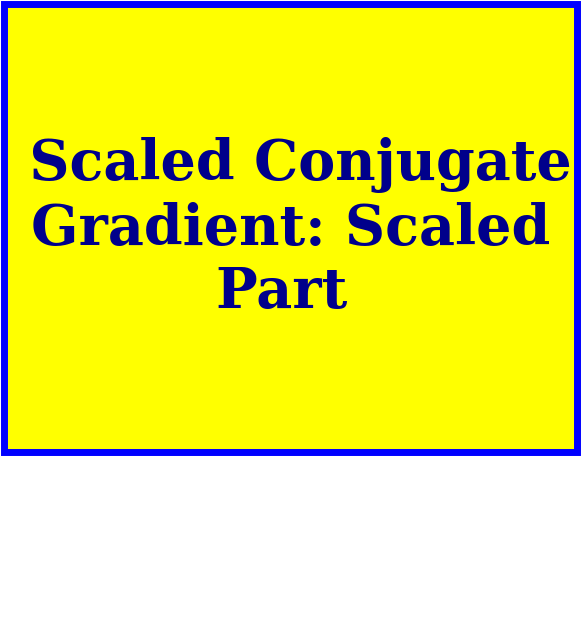

In [29]:
from topic_banner import new_topic
new_topic('Scaled Conjugate Gradient: Scaled Part')

The first derivative of an error function with respect to the
parameters of your model tells you which direction in the parameter
space to proceed to reduce the error function.  But how far do you go?
So far we have just taken a small step by subtracting a small constant
times the derivative from our current parameter values.

If we are in the vicinity of a minimum of the error function, we could
do what Newton did...approximate the function at the current parameter
value with a parabola and solve for the minimum of the parabola.  Use
this as the next guess at a good parameter value.  If the error
function is quadratic in the parameter, then we jump to the true
minimum immediately.

How would you fit a parabola to a function at a particular value of
$x$?  We can derive a way to do this using a truncated Taylor series
(google that) to approximate the function about a value of $x$. See [Taylor Series approximation, newton's method and optimization](https://suzyahyah.github.io/calculus/optimization/2018/04/06/Taylor-Series-Newtons-Method.html) by Suzanna Sia and [Taylor Series at Wolfram Mathworld](https://mathworld.wolfram.com/TaylorSeries.html#:~:text=A%20Taylor%20series%20is%20a,known%20as%20a%20Maclaurin%20series) starting at equation 29.


$$
f(x+\Delta x) \approx \hat{f}(x+\Delta x) = f(x) + f'(x) \Delta x + 
\frac{1}{2} f''(x) \Delta x^2 + 
$$

Now we want to know what value of $\Delta x$ minimizes
$\hat{f}(x+\Delta x)$.  So take its derivative and set equal to zero.

$$
\begin{align*}
\frac{d \hat{f}(x+\Delta x)}{d\Delta x} &= f'(x) + \frac{1}{2} 2 f''(x)
\Delta x\\
& = f'(x) + f''(x) \Delta x
\end{align*}
$$

Setting equal to zero we get

$$
\begin{align*}
0 &= f'(x) + f''(x) \Delta x\\
\Delta x &= -\frac{f'(x)}{f''(x)}
\end{align*}
$$

Now we can update our guess for $x$ by adding $\Delta x$ to it.  Then,
fit a new parabola at the new value of $x$, calculate $\Delta x$, and
update $x$ again.  Actually, the last equation above does the parabola
approximation and calculation of $\Delta x$.

Here is a simple example.  Say we want to find the minimum of

$$
f(x) = \sin(3x) + 0.4 x^2
$$
To calculate

$$
\begin{align*}
\Delta x &= -\frac{f'(x)}{f''(x)}
\end{align*}
$$

we need the function's first and second derivatives.  The are

$$
\begin{align*}
f'(x) &= 3 \cos(3x) + 0.8 x\\
f''(x) &= -9 \sin(3x) + 0.8
\end{align*}
$$

All together now, in python!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

Let's first check our calculus using `sympy`.

In [31]:
import sympy as sym
x = sym.Symbol('x')
x

x

In [32]:
def f(x):
    return sym.sin(3 * x) + .4 * x**2

In [33]:
f(x)

0.4*x**2 + sin(3*x)

In [34]:
sym.diff(f(x), x)

0.8*x + 3*cos(3*x)

In [35]:
sym.diff(sym.diff(f(x), x))

0.8 - 9*sin(3*x)

In [3]:
def f(x):
    return np.sin(3 * x) + 0.4 * x**2

def df(x): 
    return np.cos(3 * x) * 3 + 0.4 * 2 * x

def ddf(x):
    return -np.sin(3 * x) * 3 * 3 + 0.4 * 2

def taylorf(x, dx):
    return f(x) + df(x) * dx + 0.5 * ddf(x) * dx**2

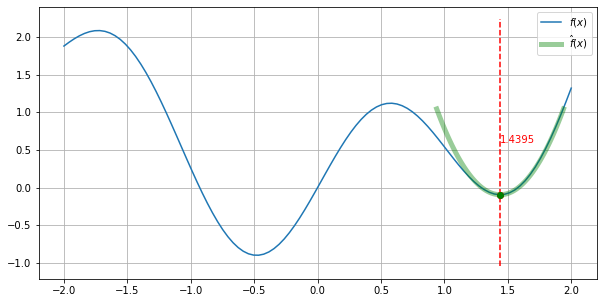

In [7]:
x = np.random.uniform(-2, 2)  # first guess at minimum
# x = 0.4

xs = np.linspace(-2, 2, num=100)  # x values for plotting

fig = plt.figure(figsize=(10, 5))

dxs = np.linspace(-0.5, 0.5, num=100)  # delta x values for taylor approximation

for rep in range(100):
    
    time.sleep(0.05) 
    
    plt.clf()
    plt.plot(xs, f(xs))
    plt.grid('on')
    plt.plot(x + dxs, taylorf(x, dxs), 'g-', linewidth=5, alpha=0.4)
    plt.plot(x, f(x), 'ro')
    
    y0, y1 = plt.ylim()
    plt.plot([x, x], [y0, y1], 'r--')
    
    x = x - df(x) / (100 + ddf(x))  # 100 added to ddf to push us away from maxima
    
    plt.plot(x, f(x), 'go')
    plt.text(x, (y0 + y1) * 0.5, f'{x:.4f}', color='r')
    
    plt.legend(('$f(x)$','$\hat{f}(x)$'))
    
    ipd.clear_output(wait=True)
    ipd.display(fig)
    
ipd.clear_output(wait=True)

This has all been for a function $f(x)$ of a single, scalar variable
$x$.  To minimize a squared error function for a neural network, $x$
will consist of all the weights of the neural network.  If all of the
weights are collected into the vector $\wv$, then the first derivative
of the squared error function, $f$, with respect to the weight vector,
$\wv$, is a vector of derivatives like $\frac{\partial f}{\partial
w_{i}}$.  This is usually written as the gradient

$$
\nabla_{\wv} f =
\left (\frac{\partial f}{\partial w_{1}}, \frac{\partial f}{\partial w_{2}},
\ldots, \frac{\partial f}{\partial w_{n}} \right ).
$$

The second derivative will be $n\times n$ matrix of values like
$\frac{\partial^2 f}{\partial w_i \partial w_j}$, usually
written as the Hessian

$$
\nabla^2_{\wv} f =
\begin{pmatrix}
\frac{\partial^2 f}{\partial w_1 \partial w_1} & 
\frac{\partial^2 f}{\partial w_1 \partial w_2} & 
\cdots
\frac{\partial^2 f}{\partial w_1 \partial w_n}\\
\frac{\partial^2 f}{\partial w_2 \partial w_1} & 
\frac{\partial^2 f}{\partial w_2 \partial w_2} & 
\cdots
\frac{\partial^2 f}{\partial w_2 \partial w_n}\\
\vdots \\
\frac{\partial^2 f}{\partial w_n \partial w_1} & 
\frac{\partial^2 f}{\partial w_n \partial w_2} & 
\cdots
\frac{\partial^2 f}{\partial w_n \partial w_n}
\end{pmatrix}
$$

It is often impractical to
construct and use the Hessian.  We
will consider ways to approximate the product of the Hessian and a
matrix as part of the Scaled Conjugate Gradient algorithm.

## The Conjugate Part
<a id='conjugate-part'></a>

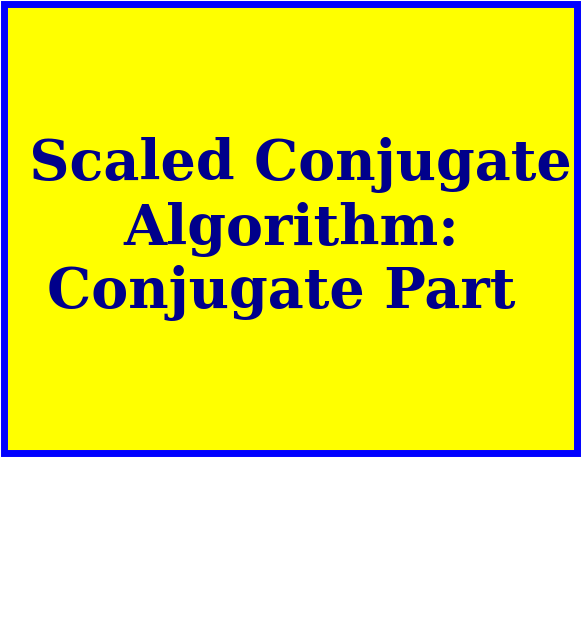

In [38]:
new_topic('Scaled Conjugate Algorithm: Conjugate Part')

Let $E(\wv)$ be the error function (mean square error over training samples) we wish to minimize by
finding the best $\wv$. Steepest descent will find new $\wv$ by
minimizing $E(\wv)$ in successive directions $\dv_0, \dv_1, \ldots$
for which $\dv_i^T \dv_j = 0$ for $i \neq j$.  In other words, the
search directions are orthogonal to each other, resulting in a zig-zag
pattern of steps, some of which are in the same directions.  

Another problem with orthogonal directions is that forcing the second
direction, for example, to be orthogonal to the first will not be in
the direction of the minimum unless the error function is quadratic
and its contours are circles.

We would rather choose a new direction based on the previous ones and
on the curvature, or second derivative, of the error function at the
current $\wv$.  This is the idea behind conjugate gradient methods.

The Scaled Conjugate Gradient (SCG) algorithm,
[Efficient
Training of Feed-Forward Neural Networks, by Moller](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.50.8063&rep=rep1&type=pdf), combines conjugate gradient directions with a local, quadratic approximation to the error function and solving
for the new value of $\wv$ that would minimize the quadratic function.
A number of additional steps are taken to improve the quadratic
approximation.

# `optimizers.py`
<a id='optimizerspy'></a>

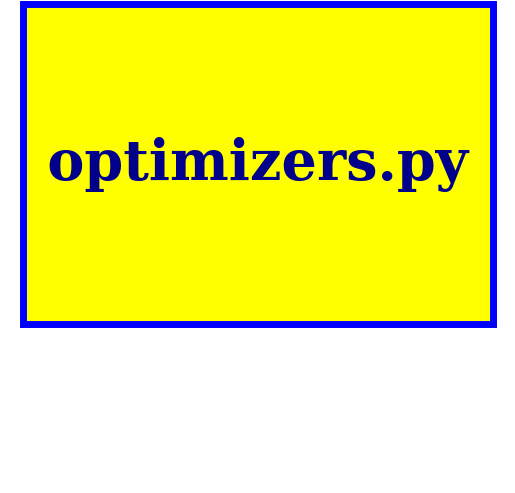

In [39]:
new_topic('optimizers.py')

The three optimization algorithms discussed so far,
- Stochastic Gradient Descent (SGD),
- Adaptive Moment Estimation (AdamW), and
- Scaled Conjugate Gradient (SCG)

Here each is implemented as a function in a class named `Optimizers`.  Each function is appended to a file named `optimizers.py`.  First, we start with the top of the file that begins with the declaration of the `Optimizers` class.

In [40]:
%%writefile optimizers.py

import numpy as np
import copy
import math
import sys  # for sys.float_info.epsilon

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        self.sgd_initialized = False
        self.scg_initialized = False
        self.adam_initialized = False


Overwriting optimizers.py


## SGD
<a id='sgd'></a>

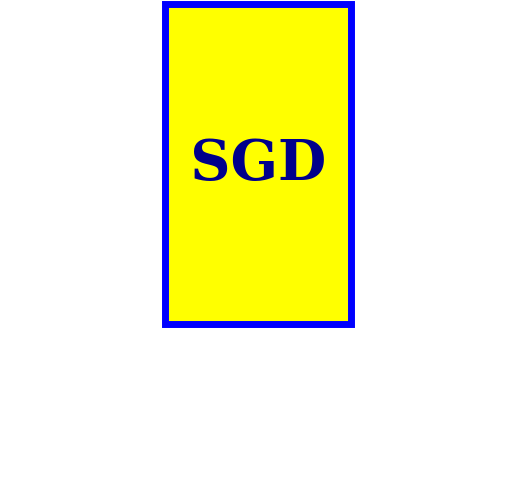

In [41]:
new_topic('SGD')

Now we define the first optimization algorithm, SGD.  We include the option of using [Nesterov accelerated gradient (NAG)](https://ruder.io/optimizing-gradient-descent/index.html#nesterovacceleratedgradient).  This link is a nice summary of many other optimizers, also.

In [16]:
%%writefile -a optimizers.py

    ######################################################################
    #### sgd
    ######################################################################
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001,
            error_convert_f=None, error_convert_name='RMSE', nesterov=False, callback_f=None, verbose=True):
        '''
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        fargs: list of arguments to pass to error_f and gradient_f
        n_epochs
        learning_rate
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        nestoerov: momentum factor for Nesterov momentum. If False, then uses zero for no momentum
        callback_f: function to call after each epoch
        verbose: if True print progress occasionally
        '''

        if not self.sgd_initialized:
            error_trace = []
            self.momentum = 0.9
            self.prev_update = 0
            if nesterov:
                self.all_weights_copy = np.zeros(self.all_weights.shape)
 
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            if not nesterov:
                
                self.prev_update = learning_rate * grad + self.momentum * self.prev_update
                # Update all weights using -= to modify their values in-place.
                self.all_weights -= self.prev_update

            else:
                self.all_weights_copy[:] = self.all_weights 

                self.all_weights -= self.momentum * self.prev_update
                error = error_f(*fargs)
                grad = gradient_f(*fargs)
                self.prev_update = learning_rate * grad + self.momentum * self.prev_update
                self.all_weights[:] = self.all_weights_copy
                self.all_weights -= self.prev_update
                
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if callback_f is not None:
                callback_f(epoch)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print('sgd: Epoch {} {}={:.5f}'.format(epoch + 1, error_convert_name, error))

        return error_trace


Appending to optimizers.py


## AdamW
<a id='adamw'></a>

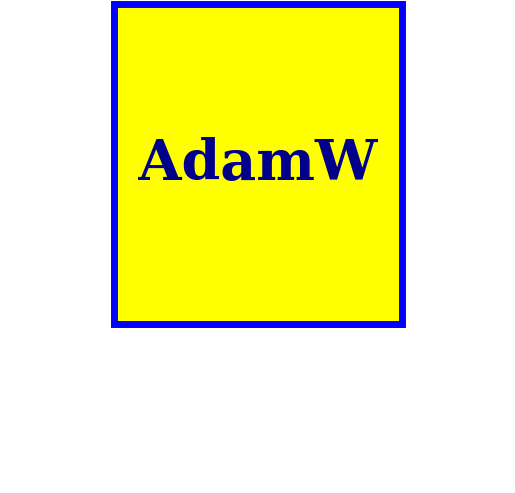

In [43]:
new_topic('AdamW')

Now we add the basic [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/index.html#adam).  

In [9]:
%%writefile -a optimizers.py

    ######################################################################
    #### adamw
    ######################################################################

    def adamw(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001,
             error_convert_f=None, error_convert_name='RMSE', weight_penalty=0, callback_f=None, verbose=True):
        '''
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        fargs: list of arguments to pass to error_f and gradient_f
        n_epochs
        learning_rate
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        callback_f: function to call after each epoch
        verbose: if True print progress occasionally
        '''

        if not self.adam_initialized:
            shape = self.all_weights.shape
            # with multiple subsets (batches) of training data.
            self.mt = np.zeros(shape)
            self.vt = np.zeros(shape)
            self.sqrt = np.sqrt
                
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.beta1t = 1
            self.beta2t = 1
            self.adam_initialized = True

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= (alpha * m_hat / (self.sqrt(v_hat) + epsilon) + 
                                 weight_penalty * self.all_weights)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if callback_f is not None:
                callback_f(epoch)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print('AdamW: Epoch {} {}={:.5f}'.format(epoch + 1, error_convert_name, error))

        return error_trace


Appending to optimizers.py


## SCG 
<a id='scg'></a>

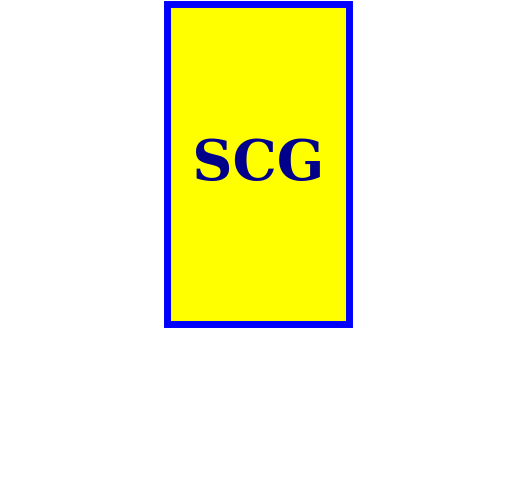

In [45]:
new_topic('SCG')

And now the Scaled Conjugate Gradient, scg, algorithm.

In [10]:
%%writefile -a optimizers.py

    ######################################################################
    #### scg
    ######################################################################

    def scg(self, error_f, gradient_f, fargs=[], n_epochs=100,
            error_convert_f=None, error_convert_name='RMSE', callback_f=None, verbose=True):

        if not self.scg_initialized:
            shape = self.all_weights.shape
            self.w_new = np.zeros(shape)
            self.w_temp = np.zeros(shape)
            self.g_new = np.zeros(shape)
            self.g_old = np.zeros(shape)
            self.g_smallstep = np.zeros(shape)
            self.search_dir = np.zeros(shape)
            self.scg_initialized = True

        sigma0 = 1.0e-6
        fold = error_f(*fargs)
        error = fold
        self.g_new[:] = gradient_f(*fargs)
        self.g_old[:] = copy.deepcopy(self.g_new)
        self.search_dir[:] = -self.g_new
        success = True				# Force calculation of directional derivs.
        nsuccess = 0				# nsuccess counts number of successes.
        beta = 1.0e-6				# Initial scale parameter. Lambda in Moeller.
        betamin = 1.0e-15 			# Lower bound on scale.
        betamax = 1.0e20			# Upper bound on scale.
        nvars = len(self.all_weights)
        iteration = 1				# j counts number of iterations
        error_trace = []

        if error_convert_f:
            error = error_convert_f(error)
        error_trace.append(error)

        # Main optimization loop.
        while iteration <= n_epochs:

            # Calculate first and second directional derivatives.
            if success:
                mu = self.search_dir @ self.g_new
                if mu >= 0:
                    self.search_dir[:] = - self.g_new
                    mu = self.search_dir.T @ self.g_new
                kappa = self.search_dir.T @ self.search_dir
                if math.isnan(kappa):
                    print('kappa', kappa)

                if kappa < sys.float_info.epsilon:
                    return error_trace

                sigma = sigma0 / math.sqrt(kappa)

                self.w_temp[:] = self.all_weights
                self.all_weights += sigma * self.search_dir
                error_f(*fargs)  # forward pass through model for intermediate variable values for gradient
                self.g_smallstep[:] = gradient_f(*fargs)
                self.all_weights[:] = self.w_temp

                theta = self.search_dir @ (self.g_smallstep - self.g_new) / sigma
                if math.isnan(theta):
                    print('theta', theta, 'sigma', sigma, 'search_dir[0]', self.search_dir[0], 'g_smallstep[0]', self.g_smallstep[0])

            ## Increase effective curvature and evaluate step size alpha.

            delta = theta + beta * kappa
            # if math.isnan(scalarv(delta)):
            if math.isnan(delta):
                print('delta is NaN', 'theta', theta, 'beta', beta, 'kappa', kappa)
            elif delta <= 0:
                delta = beta * kappa
                beta = beta - theta / kappa

            if delta == 0:
                success = False
                fnow = fold
            else:
                alpha = -mu / delta
                ## Calculate the comparison ratio Delta
                self.w_temp[:] = self.all_weights
                self.all_weights += alpha * self.search_dir
                fnew = error_f(*fargs)
                Delta = 2 * (fnew - fold) / (alpha * mu)
                if not math.isnan(Delta) and Delta  >= 0:
                    success = True
                    nsuccess += 1
                    # w[:] = wnew
                    fnow = fnew

                    if callback_f:
                        callback_f(iteration)

                else:
                    success = False
                    fnow = fold
                    self.all_weights[:] = self.w_temp

            iterationsPerPrint = math.ceil(n_epochs/10)
            if verbose and iteration % max(1, iterationsPerPrint) == 0:
                print('SCG: Iteration {} {}={:.5f}'.format(iteration, error_convert_name, error_convert_f(fnow)))

            if error_convert_f:
                error = error_convert_f(fnow)
            else:
                error = fnow
            error_trace.append(error)

            if success:

                fold = fnew
                self.g_old[:] = self.g_new
                self.g_new[:] = gradient_f(*fargs)

                # If the gradient is zero then we are done.
                gg = self.g_new @ self.g_new  # dot(gradnew, gradnew)
                if gg == 0:
                    return error_trace

            if math.isnan(Delta) or Delta < 0.25:
                beta = min(4.0 * beta, betamax)
            elif Delta > 0.75:
                beta = max(0.5 * beta, betamin)

            # Update search direction using Polak-Ribiere formula, or re-start
            # in direction of negative gradient after nparams steps.
            if nsuccess == nvars:
                self.search_dir[:] = -self.g_new
                nsuccess = 0
            elif success:
                gamma = (self.g_old - self.g_new) @ (self.g_new / mu)
                #self.search_dir[:] = gamma * self.search_dir - self.g_new
                self.search_dir *= gamma
                self.search_dir -= self.g_new

            iteration += 1

            # If we get here, then we haven't terminated in the given number of
            # iterations.

        return error_trace


Appending to optimizers.py


# Demonstrations on Simple Optimization Problems

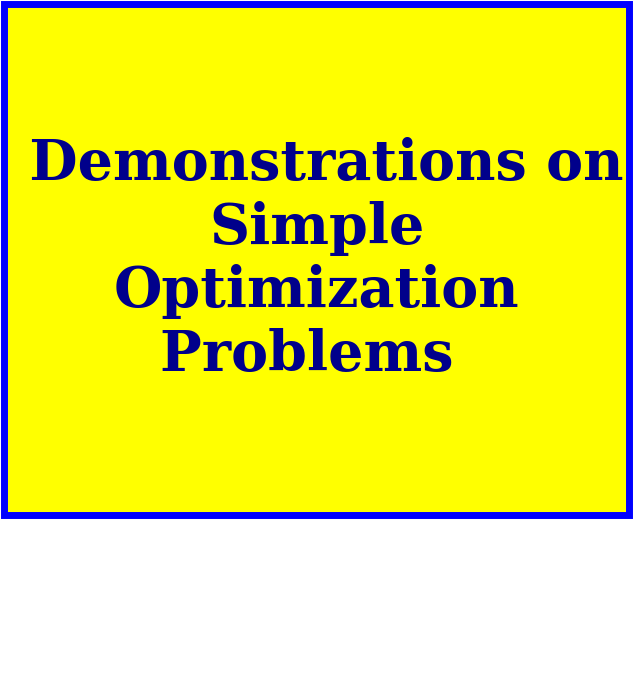

In [47]:
new_topic('Demonstrations on Simple Optimization Problems')

Each is illustrated here as they search for the minimum of the following 3-dimensional bowl.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

# x will be set at top level, so a global variable
# x will be row vector

def parabola(xmin, s):
    d = x.reshape(-1, 1) - xmin
    height = d.T @ s @ d
    height = height[0][0]  # to scalar
    return height

def parabola_gradient(xmin, s):
    d = x.reshape(-1, 1) - xmin
    return 2 * (s @ d).reshape(-1)  # must be row vector

In [13]:
!head -20 optimizers.py

'head' is not recognized as an internal or external command,
operable program or batch file.


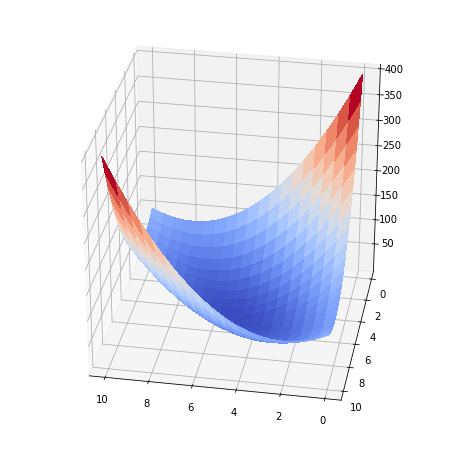

In [14]:
center = np.array([5, 5]).reshape(2, 1)
S = np.array([[5, 3], [3, 5]])

n = 20
xs = np.linspace(0, 10, n)
ys = np.linspace(0, 10, n)
X,Y = np.meshgrid(xs, ys)
both = np.vstack((X.flat, Y.flat)).T
nall = n * n

Z = np.zeros(nall)
for i in range(nall):
    x = both[i:i + 1, :]
    Z[i] = parabola(center, S)
Z = Z.reshape(n, n)

# see https://matplotlib.org/3.1.0/gallery/mplot3d/surface3d.html
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False,
                       cmap=plt.cm.coolwarm)
ax.view_init(elev=30., azim=100)

In [17]:
import optimizers as opt

def show_trace(x_start, function, function_gradient, function_args, n_epochs, learning_rates):
    global x
    
    x = x_start.copy()
    sgd_weights_trace = [x.copy()]
    def callback(epoch):
        sgd_weights_trace.append(x.copy())
    optimizer = opt.Optimizers(x)
    errors_sgd = optimizer.sgd(function, function_gradient, function_args,
                               n_epochs=n_epochs, learning_rate=learning_rates[0],
                               callback_f=callback, verbose=False)
    sgd_weights_trace = np.array(sgd_weights_trace)
    
    x = x_start.copy()
    adamw_weights_trace = [x.copy()]
    def callback(epoch):
        adamw_weights_trace.append(x.copy())
    optimizer = opt.Optimizers(x)
    errors_adamw = optimizer.adamw(function, function_gradient, function_args,
                                 n_epochs=n_epochs, learning_rate=learning_rates[1],
                                 weight_penalty=0, callback_f=callback, verbose=False)
    adamw_weights_trace = np.array(adamw_weights_trace)
    
    x = x_start.copy()
    scg_weights_trace = [x.copy()]
    def callback(epoch):
        scg_weights_trace.append(x.copy())
    optimizer = opt.Optimizers(x)
    errors_scg = optimizer.scg(function, function_gradient, function_args,
                               n_epochs=200,
                               callback_f=callback, verbose=False)
    scg_weights_trace = np.array(scg_weights_trace)

    fig = plt.figure(figsize=(15, 8))
    
    for i in range(n_epochs):
        plt.clf()
        plt.subplot(1, 2, 1)
        plt.plot(sgd_weights_trace[:i, 0], sgd_weights_trace[:i, 1], 'ro-', alpha=0.4, label='SGD')
        plt.plot(adamw_weights_trace[:i, 0], adamw_weights_trace[:i, 1], 'go-', alpha=0.2, label='Adam')
        plt.plot(scg_weights_trace[:i, 0], scg_weights_trace[:i, 1], 'ko-', alpha=0.4, label='SCG')

        plt.contourf(X, Y, Z, 20, alpha=0.3)
        plt.axis('tight')
    
        plt.legend()
        
        plt.subplot(1, 2, 2)
        steps = range(i)
        plt.plot(steps, errors_sgd[:i], 'ro-', alpha=0.4, label='SGD')
        plt.plot(steps, errors_adamw[:i], 'go-', alpha=0.2, label='Adam')
        if len(errors_scg) >= i + 1:
            plt.plot(steps, errors_scg[:i], 'ko-', alpha=0.4, label='SCG')
        else:
            plt.plot(steps[:len(errors_scg)], errors_scg, 'ko-', alpha=0.4, label='SCG')
        plt.xlabel('Step')
        plt.ylabel('Error')
        plt.legend()
        ipd.clear_output(wait=True)
        ipd.display(fig)
        time.sleep(0.01)
        
    ipd.clear_output(wait=True)

IndentationError: unexpected indent (optimizers.py, line 6)

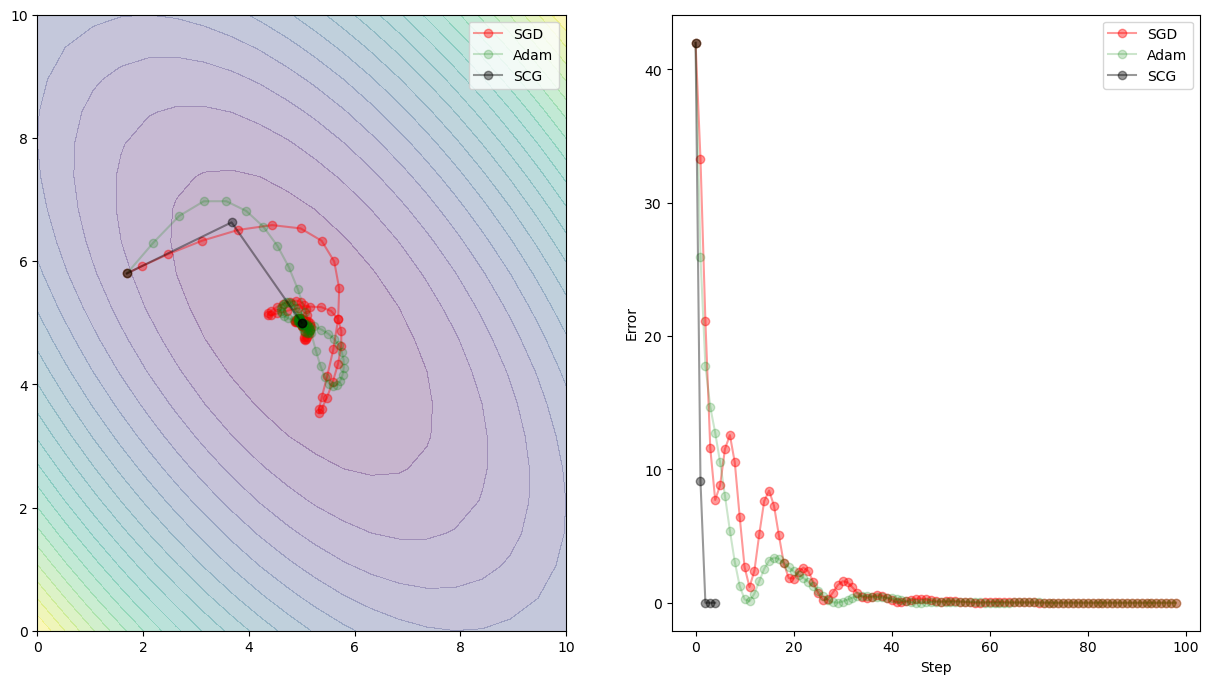

In [53]:
x_start = np.random.uniform(0, 10, 2)
show_trace(x_start, parabola, parabola_gradient, [center, S], 
           n_epochs=100, learning_rates=[0.01, 0.5]) # for sgd and adamw

Rosenbrock's function is often used to test optimization algorithms.
It is

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

In [54]:
def rosen():
    v = (1.0 - x[0])**2 + 100 * ((x[1] - x[0]**2)**2)
    return v

def rosen_gradient():
    g1 = -400 * (x[1] - x[0]**2) * x[0] - 2 * (1 - x[0])
    g2 =  200 * (x[1] - x[0]**2)
    return np.array([g1, g2])

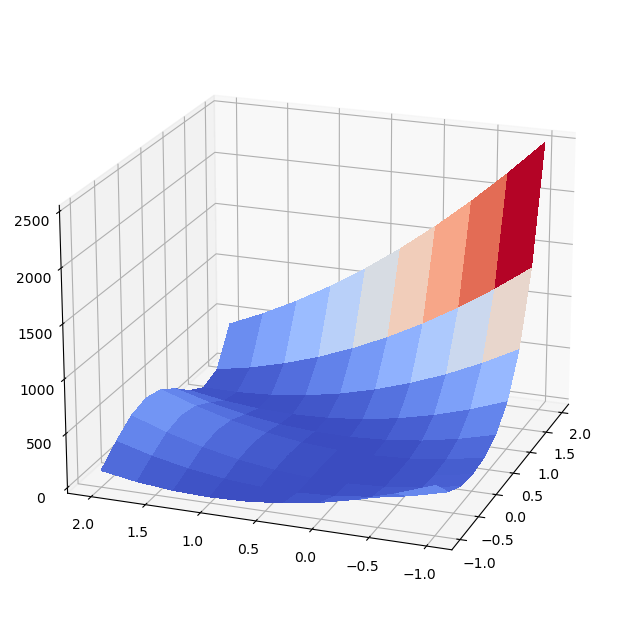

In [55]:
n = 10
xmin, xmax = -1,2
xs = np.linspace(xmin, xmax, n)
ys = np.linspace(xmin, xmax, n)
X, Y = np.meshgrid(xs, ys)    
    
both = np.vstack((X.flat, Y.flat)).T
nall = n * n
Z = np.zeros(nall)
for i in range(n * n):
    x = both[i]
    Z[i] = rosen()
Z.resize((n, n))

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False,
                       cmap=plt.cm.coolwarm)
ax.view_init(elev=20., azim=200)

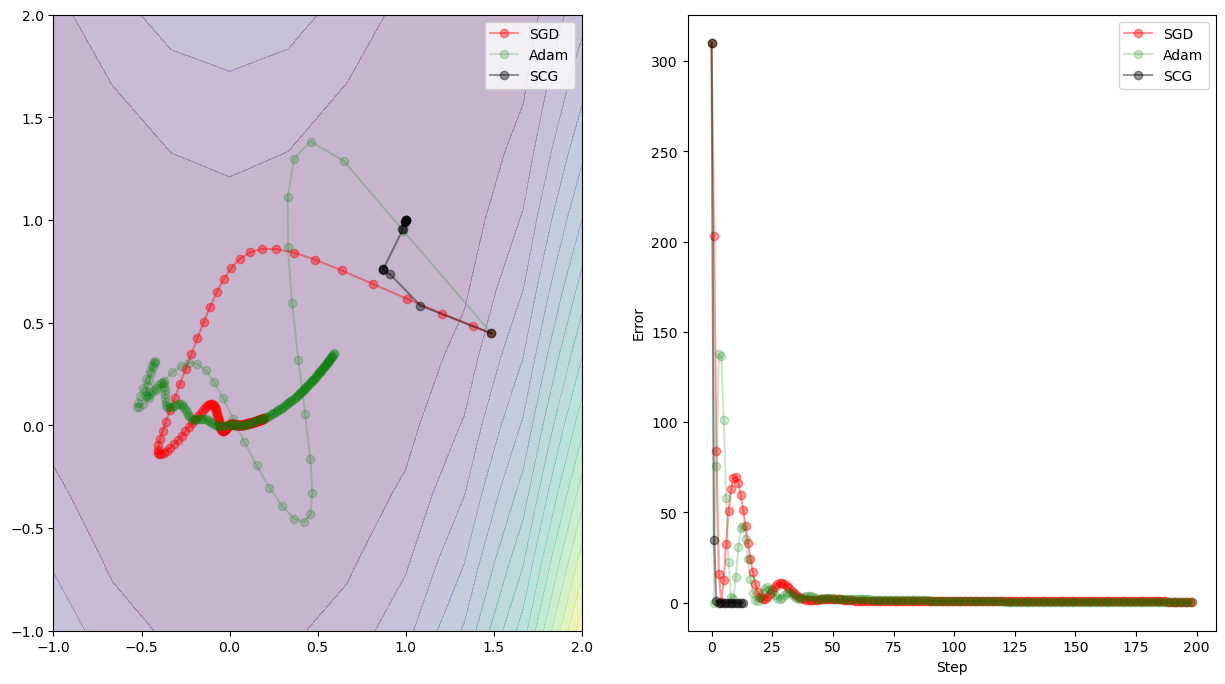

In [56]:
x_start = np.random.uniform(-1, 2, 2)
show_trace(x_start, rosen, rosen_gradient, [], n_epochs=200, learning_rates=[0.0001, 0.5])

Need a challenge?  Figure out how to plot these trajectories onto the 3D surface as shown in the previous code cell.